<a href="https://colab.research.google.com/github/MarogobaCTD/UFPR/blob/main/TRABALHO_DE_IAA011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRABALHO DE IAA011 – Visão Computacional

## 1 Extração de Características


### Setup

In [ ]:
train_directory  = r'/content/Train_4cls_amostra'
test_directory   = r'/content/Test_4cl_amostra'
output_directory = r'/content/'

In [ ]:
!unzip -o Train_Warwick.zip
!unzip -o Test_Warwick.zip

Archive:  Train_Warwick.zip
   creating: Train_4cls_amostra/
   creating: Train_4cls_amostra/0/
  inflating: Train_4cls_amostra/0/46_HER2_61709.png  
  inflating: Train_4cls_amostra/0/46_HER2_64186.png  
  inflating: Train_4cls_amostra/0/13_HER2_10243.png  
  inflating: Train_4cls_amostra/0/46_HER2_58961.png  
  inflating: Train_4cls_amostra/0/46_HER2_64180.png  
  inflating: Train_4cls_amostra/0/46_HER2_55795.png  
  inflating: Train_4cls_amostra/0/18_HER2_25188.png  
  inflating: Train_4cls_amostra/0/13_HER2_11145.png  
  inflating: Train_4cls_amostra/0/13_HER2_2910.png  
  inflating: Train_4cls_amostra/0/01_HER2_4962.png  
  inflating: Train_4cls_amostra/0/18_HER2_30785.png  
  inflating: Train_4cls_amostra/0/13_HER2_11144.png  
  inflating: Train_4cls_amostra/0/01_HER2_4153.png  
  inflating: Train_4cls_amostra/0/57_HER2_6110.png  
  inflating: Train_4cls_amostra/0/01_HER2_7841.png  
  inflating: Train_4cls_amostra/0/01_HER2_6435.png  
  inflating: Train_4cls_amostra/0/13_HER2_1139

### Importação das bibliotecas

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns


### Cálculo de LBP

In [ ]:
def calculate_lbp(img):
    # Converter para escala de cinza
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Definir parâmetros do LBP
    radius = 1
    n_points = 8 * radius

    # Criar uma imagem LBP vazia
    lbp = np.zeros_like(gray_image, dtype=np.uint8)

    # Calcular LBP
    for i in range(radius, gray_image.shape[0] - radius):
        for j in range(radius, gray_image.shape[1] - radius):
            center = gray_image[i, j]
            binary_values = []
            for p in range(n_points):
                theta = 2 * np.pi * p / n_points
                x = int(i + radius * np.sin(theta))
                y = int(j + radius * np.cos(theta))
                binary_values.append(int(gray_image[x, y] > center))

            lbp[i, j] = sum([val * (2 ** idx) for idx, val in enumerate(binary_values)])

    # Calcular o histograma LBP
    hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
    return hist / np.sum(hist)  # Normalizando o histograma

### Cálculo de VGG16

In [ ]:
def extract_vgg_features(img_path, model):
    imagem = cv2.imread(img_path)
    imagem = cv2.resize(imagem, (224, 224))  # Redimensiona para 224x224
    imagem = np.array(imagem) / 255.0  # Normaliza para [0, 1]
    imagem = np.expand_dims(imagem, axis=0)  # Adiciona uma dimensão para o batch

    # Extrair características
    features = model.predict(imagem)
    return features.flatten()

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False)
modelo_vgg = Model(inputs=vgg16.input, outputs=vgg16.output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### Criação os DataFrames das imagens

In [ ]:
def criar_dataframe_imagens(directory):
  #cria uma lista com todos os arquivos das pastas
  lista_imagens = []
  for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                lista_imagens.append(img_path)
        #print(label)

  #print(lista_imagens)
  df = pd.DataFrame(lista_imagens, columns=['imagem'])

  # Extrai o número do paciente (XX) da nomenclatura das imagens
  df['paciente_id'] = df['imagem'].apply(lambda x: x.split('/')[-1].split('_')[0])

  return df

### Separação dos dados do Treino para Treinamento e Validação

In [ ]:
def separacao_treina_validacao(directory):
  # Carregar as imagens
  df_imagens = criar_dataframe_imagens(directory)
  #print(df_imagens)

  # Separa os IDs de pacientes
  pacientes_unicos = df_imagens['paciente_id'].unique()
  print(pacientes_unicos)

  # Divide os pacientes em treino e validação (80% para treino e 20% para validação)
  num_pacientes = len(pacientes_unicos)
  num_treino = int(num_pacientes * 0.8)

  # Ordena os pacientes para garantir uma separação não randômica
  pacientes_ordenados = sorted(pacientes_unicos)
  pacientes_treino = pacientes_ordenados[:num_treino]
  pacientes_validacao = pacientes_ordenados[num_treino:]

  # Cria DataFrames para treino e validação
  df_treino = df_imagens[df_imagens['paciente_id'].isin(pacientes_treino)]
  df_validacao = df_imagens[df_imagens['paciente_id'].isin(pacientes_validacao)]

  # Exibe os DataFrames resultantes
  return df_treino, df_validacao

### Particionamento da base de Treino (80 % treino e 20% Validação)

In [ ]:
# Separação dos dataframes de treino e validacao
df_treino, df_validacao = separacao_treina_validacao(train_directory)
#print(df_treino['imagem'].apply(lambda x: x.split('/')[-2]))
#print(df_validacao)

['32' '04' '36' '25' '26' '16' '29' '24' '14' '15' '09' '22' '06' '11'
 '19' '46' '57' '13' '01' '18']


### Extração das caracteristicas

In [ ]:
def extrair_caracteristicas(df, output_directory, extrator):
  features_lbp = []
  features_vgg = []
  labels = []

  for index, row in df.iterrows():
        # Carregar a imagem
        img = cv2.imread(row['imagem'])

        # Extrair características LBP
        lbp_features = calculate_lbp(img)
        features_lbp.append(lbp_features)

        # Extrair características VGG
        vgg_features = extract_vgg_features(row['imagem'], modelo_vgg)
        features_vgg.append(vgg_features)

        # Adicionar o rótulo
        labels.append(row['imagem'].split('/')[-2])

  # Convertendo para arrays
  features_lbp = np.array(features_lbp)
  features_vgg = np.array(features_vgg)
  labels       = np.array(labels)

  # Criando DataFrames para exportação
  df_lbp    = pd.DataFrame(features_lbp)
  df_vgg    = pd.DataFrame(features_vgg)
  df_labels = pd.DataFrame(labels, columns=['Labels'])

  nome_arquivo_lbp    = extrator + '_features_lbp.csv'
  nome_arquivo_vgg    = extrator + '_features_vgg.csv'
  nome_arquivo_labels = extrator + '_labels.csv'

  # Exportando para CSV
  df_lbp.to_csv(os.path.join(output_directory, nome_arquivo_lbp), index=False)
  df_vgg.to_csv(os.path.join(output_directory, nome_arquivo_vgg), index=False)
  df_labels.to_csv(os.path.join(output_directory, nome_arquivo_labels), index=False)

  return features_lbp, features_vgg, labels

### Extrai características utilizando LBP e a CNN VGG16 (gerando um csv para cada extrator).


In [ ]:
# Extrair as caracteristicas da base de Treino
X_train_lbp, X_train_vgg, y_train = extrair_caracteristicas(df_treino, output_directory, 'train')

# Extrair as caracteristicas da base de validacao
X_valid_lbp, X_valid_vgg, y_valid = extrair_caracteristicas(df_validacao, output_directory, 'valid')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

### Calculo de Especificidade

In [ ]:
def specificity_score(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  tn = cm.diagonal().sum()  # Soma da diagonal dos verdadeiros negativos
  fp = cm.sum(axis=0) - cm.diagonal()  # Falsos positivos
  return tn / (tn + fp.sum())

### Calculo das métricas dos modelos

In [ ]:
def exibir_metricas(y_test, y_pred):
  accuracy    = accuracy_score(y_test, y_pred)
  recall      = recall_score(y_test, y_pred, average='macro')
  specificity = specificity_score(y_test, y_pred)
  f1          = f1_score(y_test, y_pred, average='macro')
  conf_matrix = confusion_matrix(y_test, y_pred)

  print(f'Acurácia: {accuracy:.4f}')
  print(f'Sensibilidade (Recall): {recall:.4f}')
  print(f'Especificidade: {specificity:.4f}')
  print(f'F1-Score: {f1:.4f}')

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.title('Matriz de Confusão')
  plt.xlabel('Previsão')
  plt.ylabel('Verdadeiro')
  plt.show()

### Random Florest

In [ ]:
def random_forest(X_train_lbp, X_train_vgg, y_train):
  # Treinar Random Forest com LBP
  rf_model_lbp = RandomForestClassifier(n_estimators=100, random_state=42)
  rf_model_lbp.fit(X_train_lbp, y_train)

  # Treinar Random Forest com VGG
  rf_model_vgg = RandomForestClassifier(n_estimators=100, random_state=42)
  rf_model_vgg.fit(X_train_vgg, y_train)  # Treinamento apenas no conjunto de treino
  return rf_model_lbp, rf_model_vgg

### SVM

In [ ]:
def svm(X_train_lbp, X_train_vgg, y_train):
  # Treinar SVM com LBP
  svm_model_lbp = SVC(kernel='linear', random_state=42)
  svm_model_lbp.fit(X_train_lbp, y_train)

  # Treinar SVM com VGG
  svm_model_vgg = SVC(kernel='linear', random_state=42)
  svm_model_vgg.fit(X_train_vgg, y_train)
  return svm_model_lbp, svm_model_vgg

### Redes Neurais Artificiais

In [ ]:
def rna(X_train_lbp, X_train_vgg, y_train):
  # Treinar RNA com LBP
  rna_model_lbp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
  rna_model_lbp.fit(X_train_lbp, y_train)

  # Treinar RNA com VGG
  rna_model_vgg = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
  rna_model_vgg.fit(X_train_vgg, y_train)
  return rna_model_lbp, rna_model_vgg

In [ ]:
def predicoes_metricas(model, X_test, y_test):
  y_pred = model.predict(X_test)
  exibir_metricas(y_test, y_pred)


### Treinamento com os dados de Treino e validação

Métricas para Randon Forest usando LBP:
Acurácia: 0.2269
Sensibilidade (Recall): 0.1133
Especificidade: 0.2269
F1-Score: 0.1736


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


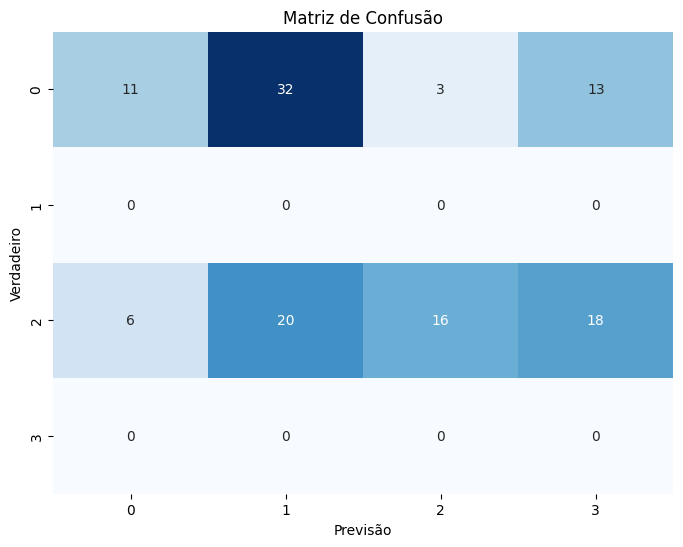

Métricas para Randon Forest usando VGG:
Acurácia: 0.3025
Sensibilidade (Recall): 0.1518
Especificidade: 0.3025
F1-Score: 0.2263


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


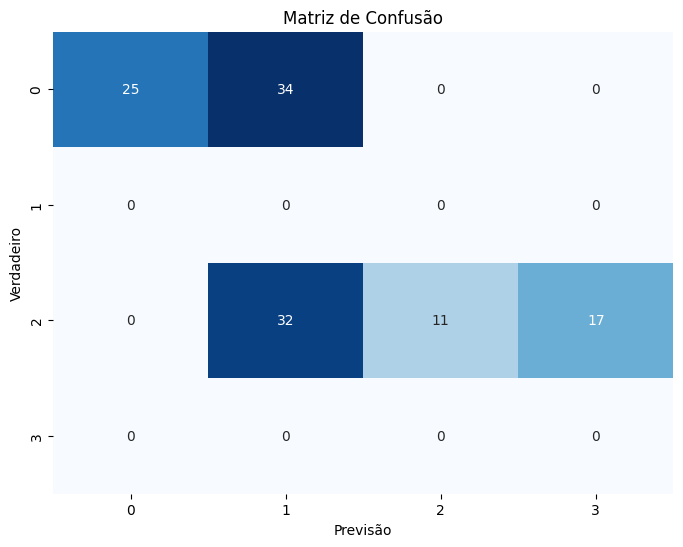

Métricas para SVM usando LBP:
Acurácia: 0.0000
Sensibilidade (Recall): 0.0000
Especificidade: 0.0000
F1-Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


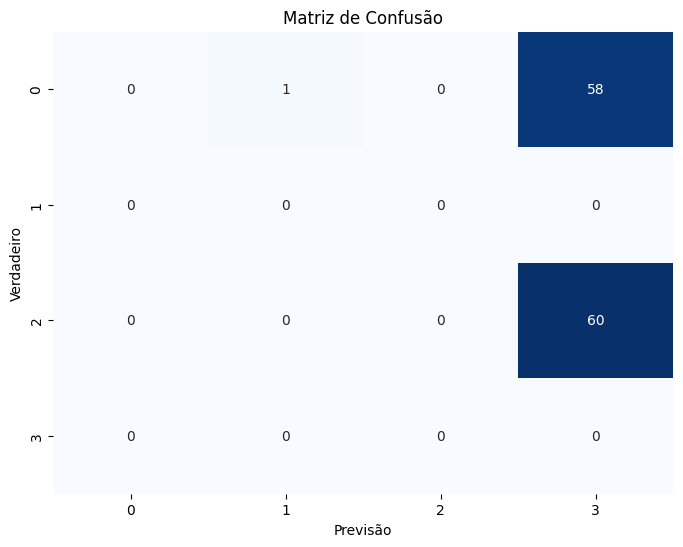

Métricas para SVM usando VGG:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Acurácia: 0.5630
Sensibilidade (Recall): 0.2819
Especificidade: 0.5630
F1-Score: 0.3588


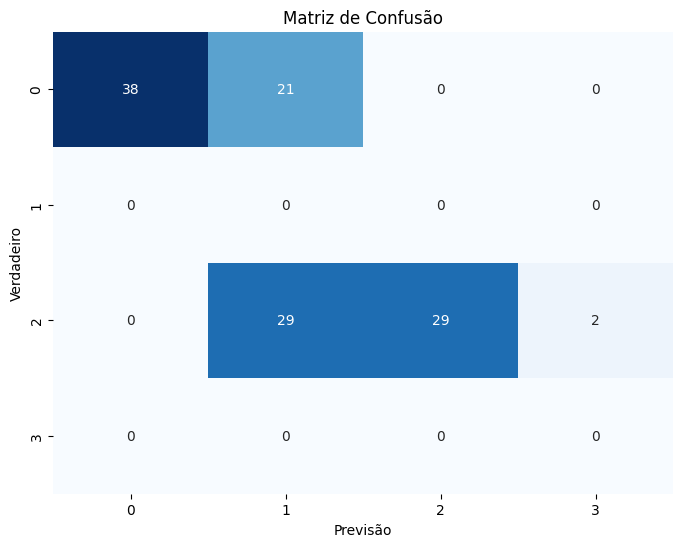

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Métricas para RNA usando LBP:
Acurácia: 0.0336
Sensibilidade (Recall): 0.0167
Especificidade: 0.0336
F1-Score: 0.0303


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


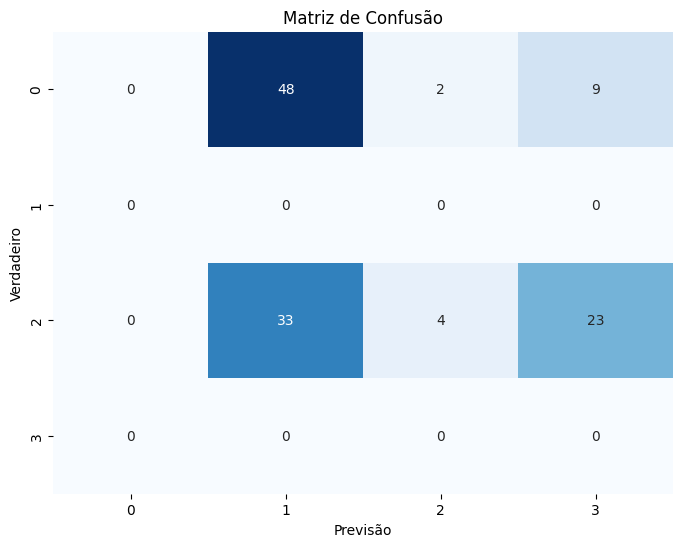

Métricas para RNA usando VGG:
Acurácia: 0.5462
Sensibilidade (Recall): 0.2734
Especificidade: 0.5462
F1-Score: 0.3524


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


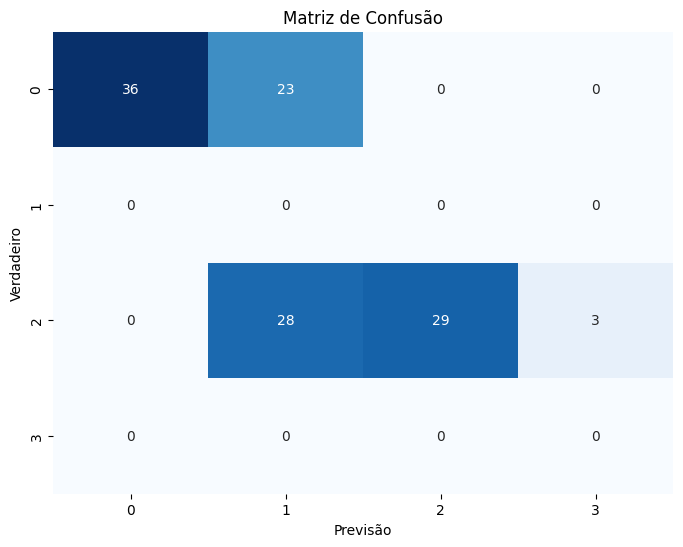

In [ ]:
# treinando o modelo e validando com os dados de validação
model_rf_lbp, model_rf_vgg = random_forest(X_train_lbp, X_train_vgg, y_train)
print(f'Métricas para Randon Forest usando LBP:')
predicoes_metricas(model_rf_lbp, X_valid_lbp, y_valid)
print(f'Métricas para Randon Forest usando VGG:')
predicoes_metricas(model_rf_vgg, X_valid_vgg, y_valid)

model_svm_lbp, model_svm_vgg = svm(X_train_lbp, X_train_vgg, y_train)
print(f'Métricas para SVM usando LBP:')
predicoes_metricas(model_svm_lbp, X_valid_lbp, y_valid)
print(f'Métricas para SVM usando VGG:')
predicoes_metricas(model_svm_vgg, X_valid_vgg, y_valid)

model_rna_lbp, model_rna_vgg = rna(X_train_lbp, X_train_vgg, y_train)
print(f'Métricas para RNA usando LBP:')
predicoes_metricas(model_rna_lbp, X_valid_lbp, y_valid)
print(f'Métricas para RNA usando VGG:')
predicoes_metricas(model_rna_vgg, X_valid_vgg, y_valid)

### Carregando a base de Teste e extraindo as características

In [ ]:
# Criação do DataFrame de Teste
df_teste = criar_dataframe_imagens(test_directory)
#print(df_teste)
# Extrair as caracteristicas da base de Teste
X_test_lbp, X_test_vgg, y_test = extrair_caracteristicas(df_teste, output_directory, 'test')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### Aplicando os modelos treinados nos dados de teste.

Métricas para Randon Forest usando LBP na base de teste:
Acurácia: 0.5391
Sensibilidade (Recall): 0.5498
Especificidade: 0.5391
F1-Score: 0.5050


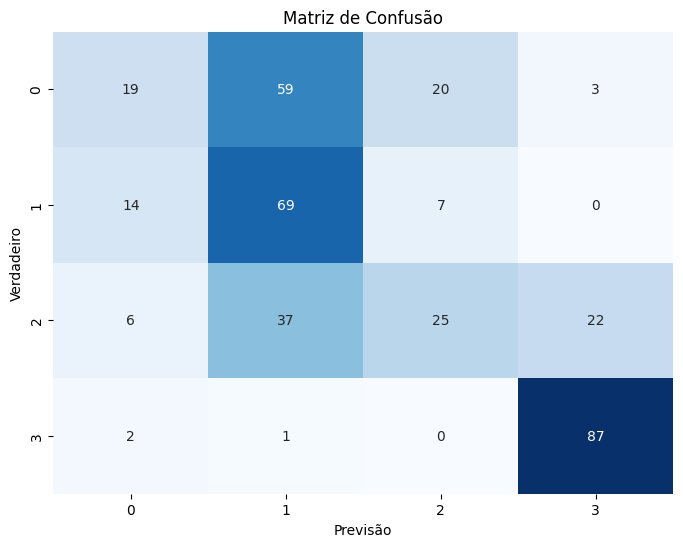

Métricas para Randon Forest usando VGG na base de teste:
Acurácia: 0.8410
Sensibilidade (Recall): 0.8422
Especificidade: 0.8410
F1-Score: 0.8358


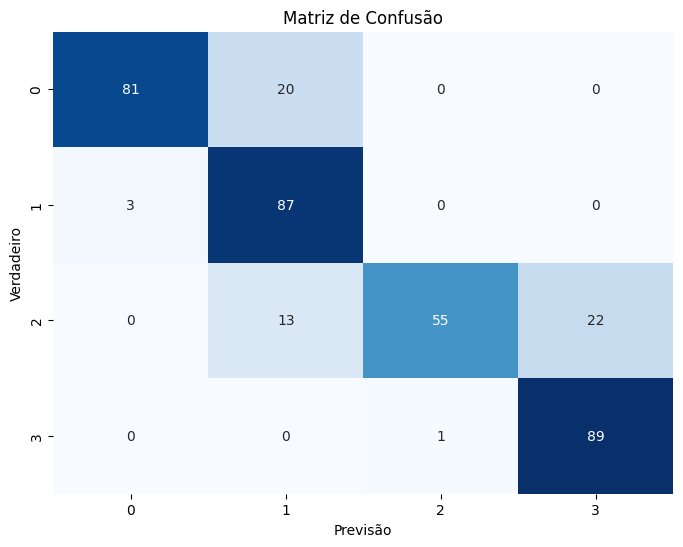

Métricas para SVM usando LBP na base de teste:
Acurácia: 0.2588
Sensibilidade (Recall): 0.2667
Especificidade: 0.2588
F1-Score: 0.1300


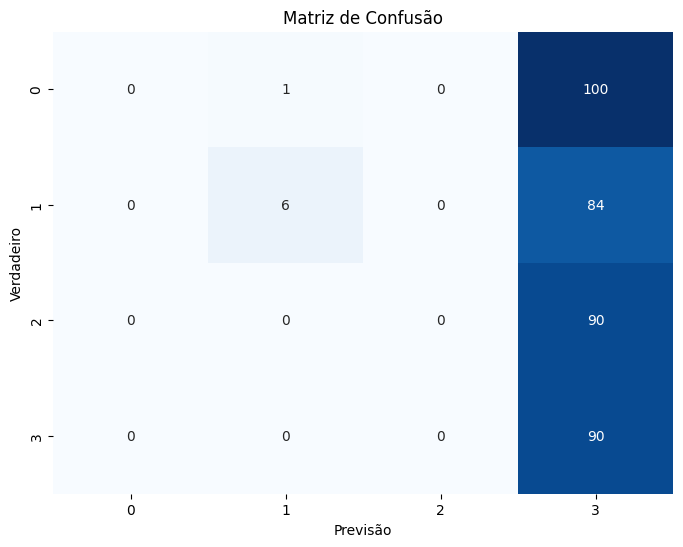

Métricas para SVM usando VGG na base de teste:
Acurácia: 0.8787
Sensibilidade (Recall): 0.8804
Especificidade: 0.8787
F1-Score: 0.8803


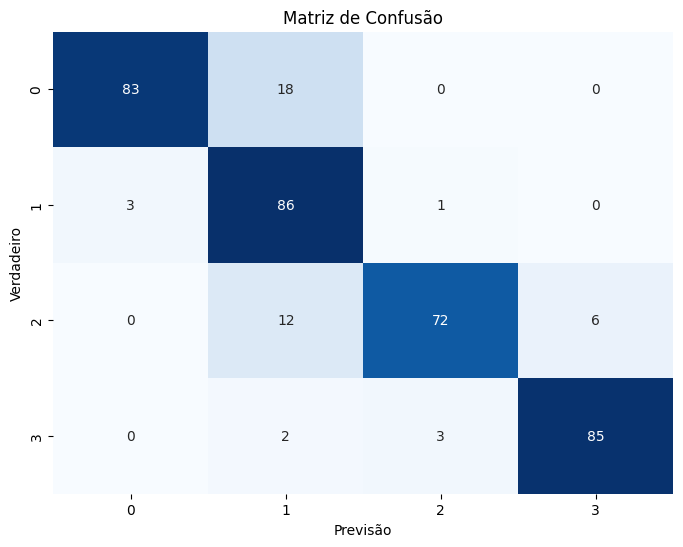

Métricas para RNA usando LBP na base de teste:
Acurácia: 0.5067
Sensibilidade (Recall): 0.5222
Especificidade: 0.5067
F1-Score: 0.3995


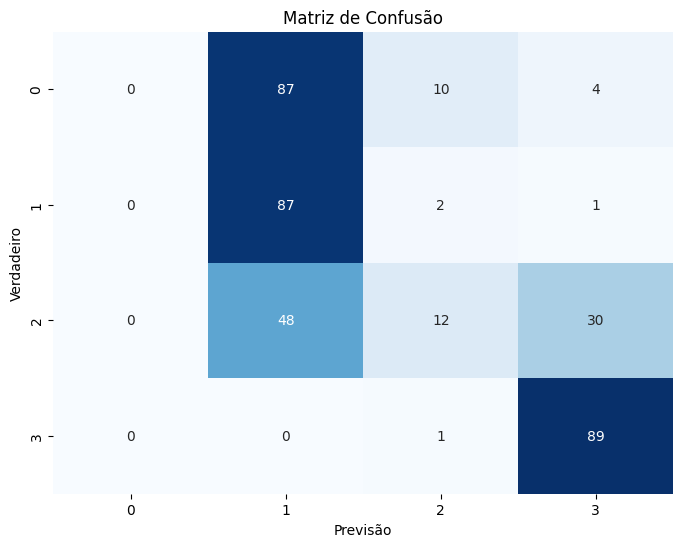

Métricas para RNA usando VGG na base de teste:
Acurácia: 0.8787
Sensibilidade (Recall): 0.8798
Especificidade: 0.8787
F1-Score: 0.8783


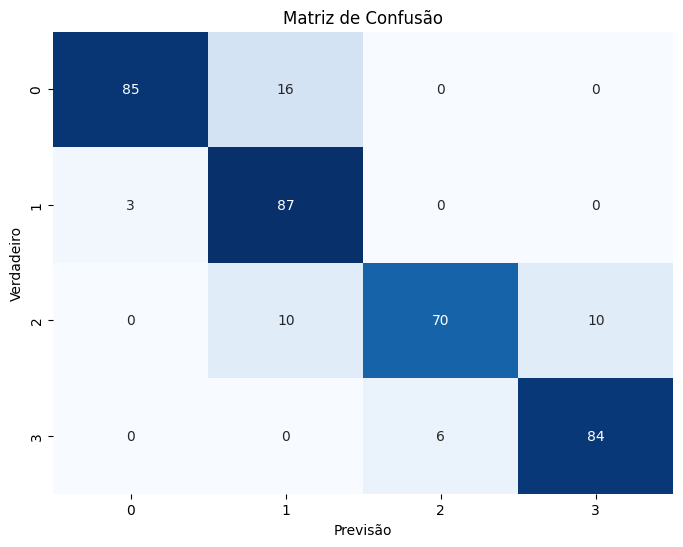

In [ ]:
# Execução o modelo treinado na base de teste

print(f'Métricas para Randon Forest usando LBP na base de teste:')
predicoes_metricas(model_rf_lbp, X_test_lbp, y_test)
print(f'Métricas para Randon Forest usando VGG na base de teste:')
predicoes_metricas(model_rf_vgg, X_test_vgg, y_test)

print(f'Métricas para SVM usando LBP na base de teste:')
predicoes_metricas(model_svm_lbp, X_test_lbp, y_test)
print(f'Métricas para SVM usando VGG na base de teste:')
predicoes_metricas(model_svm_vgg, X_test_vgg, y_test)

print(f'Métricas para RNA usando LBP na base de teste:')
predicoes_metricas(model_rna_lbp, X_test_lbp, y_test)
print(f'Métricas para RNA usando VGG na base de teste:')
predicoes_metricas(model_rna_vgg, X_test_vgg, y_test)


### Conclusão

###### Teste

## Redes Neurais